[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


📂 Please upload ALL FOUR CSV FILES together:


Saving hate_speech_simple.csv to hate_speech_simple.csv
Saving HateSpeechDataset.csv to HateSpeechDataset.csv
Saving labeled_data.csv to labeled_data.csv
Saving test.csv to test.csv
✅ Loaded hate_speech_simple.csv — shape: (135556, 2)
✅ Loaded HateSpeechDataset.csv — shape: (440906, 3)
✅ Loaded labeled_data.csv — shape: (24783, 7)
✅ Loaded test.csv — shape: (3728, 12)

All datasets loaded successfully!

--- hate_speech_simple.csv ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135556 entries, 0 to 135555
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    135556 non-null  object
 1   label   135556 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.1+ MB
None
                                                text  label
0  Yes indeed. She sort of reminds me of the elde...      0
1  The trans women reading this tweet right now i...      0
Missing values:
 text     0
label    0
dtype: int64
Duplicates: 95991

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


✅ Tokenization Completed

--- Basic Stats ---
count    64331.000000
mean        19.890488
std         16.783968
min          0.000000
25%          9.000000
50%         15.000000
75%         25.000000
max        124.000000
Name: text_length, dtype: float64


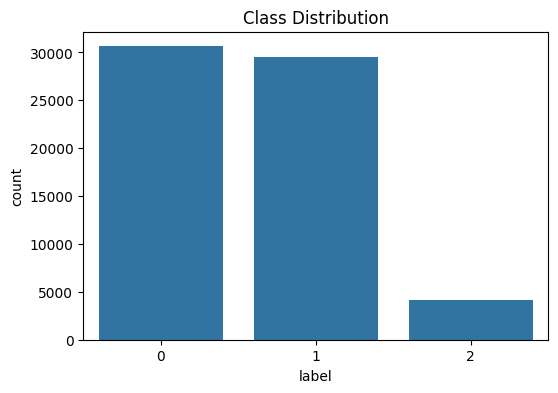

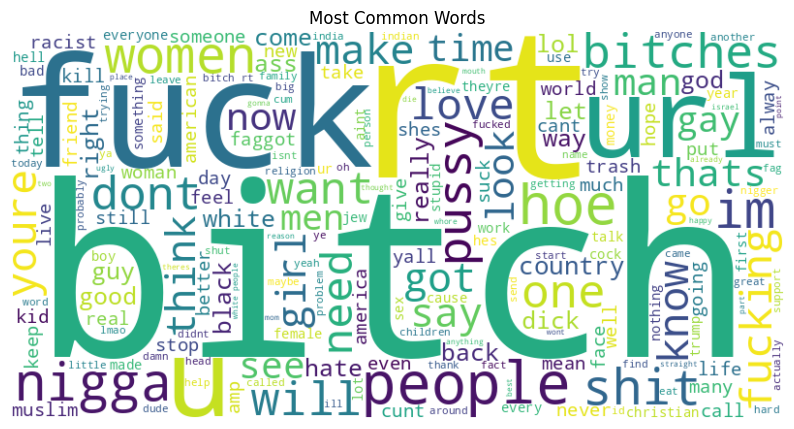

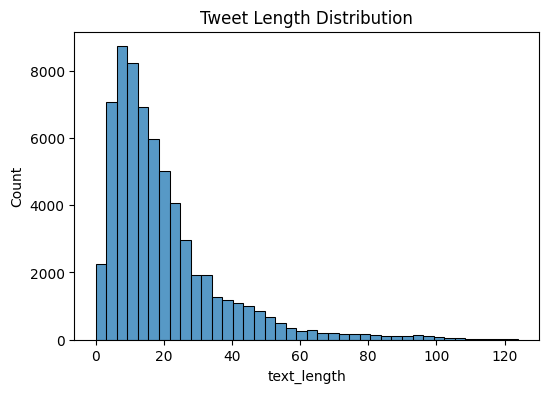


💾 Saved cleaned dataset as: cleaned_hate_speech_dataset.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ All Done! You now have a cleaned, merged, tokenized dataset ready for model building.


In [ ]:
# ================================
# HATE SPEECH DETECTION - DATA PREPARATION & EXPLORATION
# Handles Multiple Datasets Automatically
# ================================

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import nltk
nltk.download('punkt')

# ================================
# Step 1: Upload All Datasets
# ================================
from google.colab import files
print("📂 Please upload ALL FOUR CSV FILES together:")
uploaded = files.upload()

datasets = {}
for fn in uploaded.keys():
    try:
        df = pd.read_csv(fn, encoding='utf-8', engine='python')
    except:
        df = pd.read_csv(fn, encoding='latin1', engine='python')
    datasets[fn] = df
    print(f"✅ Loaded {fn} — shape: {df.shape}")

print("\nAll datasets loaded successfully!")

# ================================
# Step 2: Explore Each Dataset
# ================================
for name, df in datasets.items():
    print(f"\n--- {name} ---")
    print(df.info())
    print(df.head(2))
    print("Missing values:\n", df.isnull().sum())
    print("Duplicates:", df.duplicated().sum())
    print("-" * 50)

# ================================
# Step 3: Standardize and Merge
# ================================

# We'll identify text + label columns automatically
merged = []

for name, df in datasets.items():
    text_col, label_col = None, None
    for col in df.columns:
        if 'text' in col.lower() or 'tweet' in col.lower() or 'message' in col.lower():
            text_col = col
        if 'label' in col.lower() or 'class' in col.lower() or 'hate' in col.lower() or 'target' in col.lower():
            label_col = col

    if text_col and label_col:
        temp = df[[text_col, label_col]].copy()
        temp.columns = ['text', 'label']
        merged.append(temp)
        print(f"Merged from {name}: columns ({text_col}, {label_col})")
    elif text_col:
        temp = df[[text_col]].copy()
        temp['label'] = np.nan
        temp.columns = ['text', 'label']
        merged.append(temp)
        print(f"Merged from {name}: only text column found")

# Combine all
combined_df = pd.concat(merged, axis=0, ignore_index=True)
print("\n✅ Combined Dataset Shape:", combined_df.shape)

# Drop duplicates, nulls
combined_df.drop_duplicates(subset='text', inplace=True)
combined_df.dropna(subset=['text'], inplace=True)
print("✅ After cleaning:", combined_df.shape)

# ================================
# Step 4: Basic Label Inspection
# ================================
print("\nLabel value counts (if available):")
if combined_df['label'].notnull().sum() > 0:
    print(combined_df['label'].value_counts())
else:
    print("⚠️ No label data in some datasets (they may be unlabeled).")

# ================================
# Step 5: Text Cleaning Function
# ================================
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

combined_df['clean_text'] = combined_df['text'].apply(clean_text)
print("\n✅ Text Cleaning Completed")

# ================================
# Step 6: Tokenization (Fixed)
# ================================
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')  # required for some NLTK versions

from nltk.tokenize import word_tokenize

combined_df['tokens'] = combined_df['clean_text'].apply(word_tokenize)
print("✅ Tokenization Completed")


# ================================
# Step 7: EDA
# ================================
print("\n--- Basic Stats ---")
combined_df['text_length'] = combined_df['clean_text'].apply(lambda x: len(x.split()))
print(combined_df['text_length'].describe())

# Class distribution (if labels exist)
if combined_df['label'].notnull().sum() > 0:
    plt.figure(figsize=(6,4))
    sns.countplot(x='label', data=combined_df)
    plt.title("Class Distribution")
    plt.show()

# WordCloud
all_words = ' '.join(combined_df['clean_text'])
plt.figure(figsize=(10,6))
wc = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words")
plt.show()

# Tweet length histogram
plt.figure(figsize=(6,4))
sns.histplot(combined_df['text_length'], bins=40)
plt.title("Tweet Length Distribution")
plt.show()

# ================================
# Step 8: Save Final Clean Dataset
# ================================
output_name = "cleaned_hate_speech_dataset.csv"
combined_df.to_csv(output_name, index=False)
print(f"\n💾 Saved cleaned dataset as: {output_name}")

from google.colab import files
files.download(output_name)

print("\n✅ All Done! You now have a cleaned, merged, tokenized dataset ready for model building.")


In [ ]:
from google.colab import files
files.download("cleaned_hate_speech_dataset.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install emoji


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 7.6 MB/s eta 0:00:00


In [ ]:
# ===============================
# STEP 1: Import Libraries
# ===============================
import pandas as pd
import numpy as np
import re
import nltk
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from google.colab import files

# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# ===============================
# STEP 2: Upload Datasets
# ===============================
print("📂 Please upload all four CSV files together:")
uploaded = files.upload()

dataframes = []
for filename in uploaded.keys():
    try:
        df = pd.read_csv(filename, encoding='utf-8')
    except Exception as e:
        print(f"UTF-8 failed for {filename}, trying latin1...")
        df = pd.read_csv(filename, encoding='latin1')

    print(f"✅ Loaded {filename} — shape: {df.shape}")
    dataframes.append((filename, df))

# ====================================================
# ===> STEP 3 (NEW LOGIC): Standardize and Merge  <===
# ====================================================
print("\n🔍 Standardizing labels during merge...")
merged_dfs = []

# Define maps for EACH file
# 1 = Hateful/Offensive, 0 = Non-Hateful

# For labeled_data.csv: {0: Hate, 1: Offensive, 2: Neither}
# This implements your request: (0, 1) -> 1, and (2) -> 0
map_labeled_data = {0: 1, 1: 1, 2: 0}

# For hate_speech_simple.csv: {1: Hateful, 0: Non-hateful}
map_simple = {1: 1, 0: 0}

# For HateSpeechDataset.csv: {'1': Hateful, '0': Non-hateful}
map_hatespeechdataset = {'1': 1, '0': 0}

# For test.csv: {'hateful': Hateful, 'non-hateful': Non-hateful}
map_test = {'hateful': 1, 'non-hateful': 0}


for name, df in dataframes:
    name_lower = name.lower()
    df_temp = df.copy() # Avoid SettingWithCopyWarning

    if 'hate_speech_simple' in name_lower:
        df_temp = df_temp[['text', 'label']]
        df_temp['label'] = df_temp['label'].map(map_simple)
        merged_dfs.append(df_temp)
        print(f"Processed {name} with its map.")

    elif 'labeled_data' in name_lower:
        df_temp = df_temp.rename(columns={'tweet': 'text', 'class': 'label'})
        df_temp = df_temp[['text', 'label']]
        df_temp['label'] = df_temp['label'].map(map_labeled_data)
        merged_dfs.append(df_temp)
        print(f"Processed {name} with your custom map (0,1->1; 2->0).")

    elif 'hatespeechdataset' in name_lower:
        df_temp = df_temp.rename(columns={'Content': 'text', 'Label': 'label'})
        df_temp = df_temp[['text', 'label']]
        df_temp['label'] = df_temp['label'].map(map_hatespeechdataset)
        merged_dfs.append(df_temp)
        print(f"Processed {name} with its map.")

    elif 'test' in name_lower:
        df_temp = df_temp.rename(columns={'test_case': 'text', 'label_gold': 'label'})
        df_temp = df_temp[['text', 'label']]
        df_temp['label'] = df_temp['label'].map(map_test)
        merged_dfs.append(df_temp)
        print(f"Processed {name} with its map.")

# Combine all
combined_df = pd.concat(merged_dfs, ignore_index=True)
print(f"\n Combined dataset shape (before dedup): {combined_df.shape}")

# Drop missing text and duplicates
combined_df.dropna(subset=['text'], inplace=True)
combined_df.drop_duplicates(subset=['text'], inplace=True)
# Drop rows where label mapping might have failed (became NaN)
combined_df.dropna(subset=['label'], inplace=True)
# Convert label to integer
combined_df['label'] = combined_df['label'].astype(int)

combined_df.reset_index(drop=True, inplace=True)
print(f" Combined dataset shape (after dedup/cleaning): {combined_df.shape}")

print("\n Labels standardized and merged successfully!")
print("Final label counts (should only be 0 and 1):")
print(combined_df['label'].value_counts(dropna=False))
# ====================================================
# ===> END OF NEW STEP 3 <===
# ====================================================


# ===============================
# STEP 4: Deep Cleaning Function
# ===============================
def deep_clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)       # remove URLs
    text = re.sub(r"@\w+|#\w+", "", text)           # remove mentions & hashtags
    text = emoji.replace_emoji(text, replace='')    # remove emojis
    text = re.sub(r"[^a-z\s]", " ", text)           # remove non-letters
    text = re.sub(r"\s+", " ", text).strip()        # normalize spaces
    return text

combined_df['clean_text'] = combined_df['text'].apply(deep_clean_text)
print("\n Text cleaned successfully!")

# ===============================
# STEP 5: Tokenization + Stopword Removal + Lemmatization
# ===============================
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_tokens(text):
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens

combined_df['tokens'] = combined_df['clean_text'].apply(preprocess_tokens)
print(" Tokenization completed successfully!")

# ===============================
# STEP 6: Save Final Cleaned Dataset
# ===============================
output_file = "cleaned_hate_speech_dataset_v3.csv"
combined_df.to_csv(output_file, index=False)
print(f" Saved final cleaned dataset as: {output_file}")

# ===============================
# STEP 7: Download Cleaned File
# ===============================
files.download(output_file)
print(" Download complete.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


📂 Please upload all four CSV files together:


Saving hate_speech_simple.csv to hate_speech_simple.csv
Saving HateSpeechDataset.csv to HateSpeechDataset.csv
Saving labeled_data.csv to labeled_data.csv
Saving test.csv to test.csv
✅ Loaded hate_speech_simple.csv — shape: (135556, 2)
✅ Loaded HateSpeechDataset.csv — shape: (440906, 3)
✅ Loaded labeled_data.csv — shape: (24783, 7)
✅ Loaded test.csv — shape: (3728, 12)

🔍 Standardizing labels during merge...
Processed hate_speech_simple.csv with its map.
Processed HateSpeechDataset.csv with its map.
Processed labeled_data.csv with your custom map (0,1->1; 2->0).
Processed test.csv with its map.

 Combined dataset shape (before dedup): (604973, 2)
 Combined dataset shape (after dedup/cleaning): (485475, 2)

 Labels standardized and merged successfully!
Final label counts (should only be 0 and 1):
label
0    376015
1    109460
Name: count, dtype: int64

 Text cleaned successfully!
 Tokenization completed successfully!
 Saved final cleaned dataset as: cleaned_hate_speech_dataset_v3.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Download complete.
